### A new Find-Crop method:
#### February 14th
Francis Rossmann
___
___
This is a notebook to demonstrate an idea for a new method to make ellipsoidal pointclouds (as opposed to rectangular polygons in lat/lon) for Beau's study. This is motivated by the idea that we should have control over how much area is sampled inside and outside of the crater, and if the craters are circles then the ROIs should probably be circles (or really really big rectangles I guess). 

BUT this method doesn't address the problem of masking overlapping craters, craters inside of craters, etc. & so this might not implement easily. You also can't really run this because the filepaths are pointing to my directories and you may not have all the dependencies installed, so this is really for demonstration only! Also emphasizing this is just an idea and I'm not committed to doing this, which is why I'm looking for your feedback.

___
___

#### Method: 
The spreadsheet Beau provided has the crater centre coordinates in XYZ & lat/lon, as well as the crater radius ($r_{crater}$). From these parameters we can make a circular ROI with some radius that encloses the crater on all sides. But, if we want to make a circular ROI about the crater then we need to know something about the local topography so that we can orient the ROI properly in space.

I've done this by fitting a plane to the surface of a 12m SPC model, then parametrizing a circle with $n\cdot r_{crater}$ on that plane where $n$ is just some scaling factor that says 'I want the radius of the ROI to be $n$ times the radius of the ROI'. The circle is parametrized as: 

$$\vec{r}(t)=\vec{c}+\rho \cos t \hat{\imath}^{\prime}+\rho \sin t \hat{\jmath}^{\prime} \quad 0 \leq t \leq 2 \pi$$

Where $\rho$ is the crater radius and $\hat{\imath}^{\prime}$,  $\hat{\jmath}^{\prime}$ are mutually perpendicular unit vectors that lay in the plane fit to the SPC pointcloud. (ref: http://www.math.ubc.ca/~feldman/m263/circle.pdf). 


___
*In the example below, $n$ is chosen as $n=1.5$.*
 ___


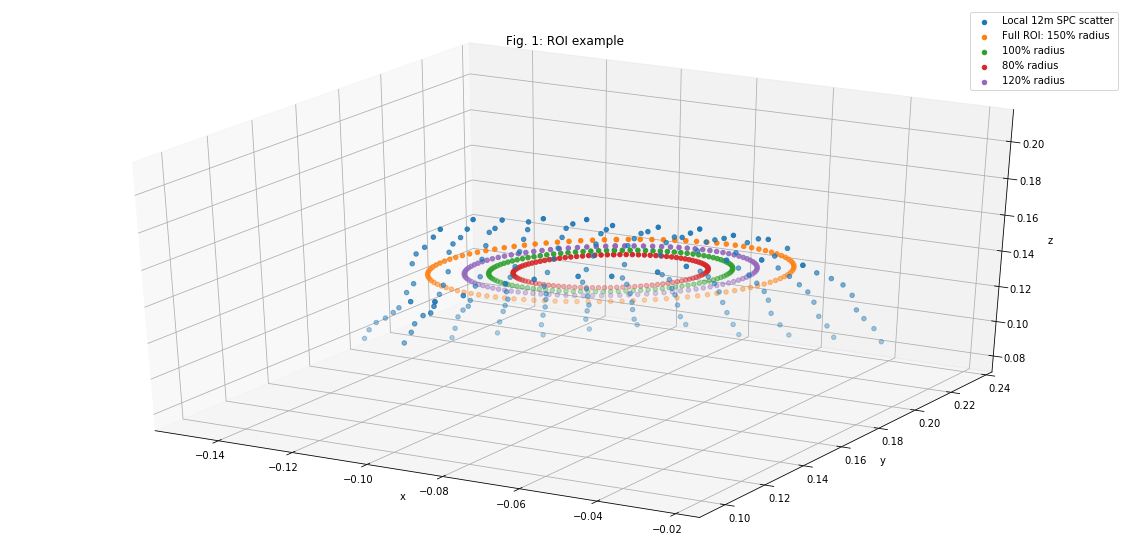

In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from shapely.geometry import Polygon
import shapely.affinity as affinity
import contexttimer
import time
import warnings
from astropy import coordinates as coords
import scipy.io as sio


def fastread_xyz(filepath):
    with contexttimer.Timer(time.perf_counter) as pure_wall:
        with contexttimer.Timer(time.process_time) as pure_cpu:
            dataframe = pd.read_csv(
                filepath,
                header=None,
                sep="\s+",
                keep_default_na=False,
                names=["x", "y", "z"],
            )
    warnings.simplefilter("error", UserWarning)
    if dataframe.isnull().all().any():
        warnings.warn("One or more dataframe columns are null", UserWarning)
        warnings.showwarning()
    data = dataframe.to_numpy()
    return data


def cart2sph(xyz):
    radius, lat, lon = coords.cartesian_to_spherical(xyz[:, 0], xyz[:, 1], xyz[:, 2])
    lat = coords.Latitude(lat).degree
    lon = coords.Longitude(lon).degree
    return lon, lat, radius


def parametrizeCircle(centre, radius, V):
    theta = np.linspace(0, 2 * np.pi, 100)  #% Angle vector for parametrizing a circle
    rx = centre[0] + radius * np.cos(theta) * V[0, 2] + radius * np.sin(theta) * V[0, 1]
    ry = centre[1] + radius * np.cos(theta) * V[1, 2] + radius * np.sin(theta) * V[1, 1]
    rz = centre[2] + radius * np.cos(theta) * V[2, 2] + radius * np.sin(theta) * V[2, 1]
    theCircle = np.array([rx, ry, rz])
    return theCircle.transpose()


# Load a 12m v052 SPC model: 
filepathSPC = "/Users/francis/Nextcloud/code_3d_FR/data/g_12630mm_spc_obj_v052_xyz.txt"
theSPC = fastread_xyz(filepathSPC)
lon, lat, radius = cart2sph(theSPC)

# Load Beau's table:
filepathTable = "/Users/francis/Nextcloud/code_3d_FR/data/2020_06_bt_final_ma_fr.xls"
theTable = pd.read_excel(filepathTable)

# Handy things:
rad2deg = 180 / np.pi
deg2rad = np.pi / 180
theta = np.linspace(0, 2 * np.pi, 50)

# Example crater. n0.1029:
craterID = 1029
theRadius = theTable["diameter_km_"].loc[craterID] / 2
theCentre = np.array(
    [theTable["longitude_deg_"].loc[craterID], theTable["latitude_deg_"].loc[craterID]]
)
theCentreXYZ = np.array(
    [
        theTable["x_km_"].loc[craterID],
        theTable["y_km_"].loc[craterID],
        theTable["z_km_"].loc[craterID],
    ]
)

# Find distance per degree of latitude and longitude: 
latKM = 0.5 * np.cos(theCentre[1] * deg2rad) / (180 / np.pi)
lonKM = 0.5 / (180 / np.pi)

# Make a rectangular boundary for the local SPC pointcloud
# where the length in latitude and longitude is the distance in degrees
# corresponding to a length of 10 times the crater radius.
lonCorners = np.array(
    [theCentre[0] - 5 * theRadius / lonKM, theCentre[0] + 5 * theRadius / lonKM]
)
latCorners = np.array(
    [theCentre[1] - 5 * theRadius / latKM, theCentre[1] + 5 * theRadius / latKM]
)

localSPC = theSPC[
    (lon > lonCorners[0])
    & (lon < lonCorners[1])
    & (lat > latCorners[0])
    & (lat < latCorners[1]),
    :,
]

# Fit a plane to the local SPC cloud:
covarMat = np.cov(localSPC.T)
eigVals, eigVecs = np.linalg.eig(covarMat)

# Make a bunch of circles laying parallel to the best fit plane at
# radii of 1.5, 1.2, 1 and 0.8 crater radii:
aspectROI = 1.5
circleROI = parametrizeCircle(theCentreXYZ, aspectROI*theRadius, eigVecs)
circle100 = parametrizeCircle(theCentreXYZ, 1*theRadius, eigVecs)
circle80 = parametrizeCircle(theCentreXYZ, 0.8*theRadius, eigVecs)
circle120 = parametrizeCircle(theCentreXYZ, 1.2*theRadius, eigVecs)


%matplotlib inline
fig = plt.figure(figsize=(20, 10))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(localSPC[:, 0], localSPC[:, 1], localSPC[:, 2],label='Local 12m SPC scatter')
ax.scatter(circleROI[:, 0], circleROI[:, 1], circleROI[:, 2],label='Full ROI: 150% radius')
ax.scatter(circle100[:, 0], circle100[:, 1], circle100[:, 2],label='100% radius')
ax.scatter(circle80[:, 0], circle80[:, 1], circle80[:, 2],label='80% radius')
ax.scatter(circle120[:, 0], circle120[:, 1], circle120[:, 2],label='120% radius')
plt.legend();
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z');
plt.title('Fig. 1: ROI example');


___
*Figure 1* above shows the results of parametrizing the ROI boundary. The scatter represents the 12m SPC model to which the best fit plane is fit. The orange annulus represents the ROI boundary. Green is the crater rim (100% radius), red is 80% radius, purple is 120%. 

The roughness calculation would be so that points 'inside' are within the 80% annulus, and the points 'outside' would be on the outside of the 120% annulus (and maybe bounded on the outside too to normalize inside:outside area). For the analysis I might place the annuli which define the crater inside/outside on a plane thats fit to the OLA pointcloud instead of the SPC cloud, but thats for later.

#### Now we can find scans that intersect the ROI:

Instead of finding scans that are within some arclength of the crater centre we could just find scans that overlap the ROI by some percentage of the ROI's total area, so the percentage of overlap would be given as 

$$overlap = 100\cdot A_{overlap}/A_{ROI}$$

I chose 50% for this example.

I haven't made a proper workaround for when a scan boundary is on either side of the prime meridian yet but theres a temporary line in the below code that just scraps the scan boundary polygons with a big area (meaning the polygons that get smeared across the prime meridian and therefore intersect the ROI). 

Relevant scans are:
 [['190705_ola_scil2Aid04052t_XYZ.txt'], ['190705_ola_scil2Aid04053t_XYZ.txt'], ['190706_ola_scil2Aid04078t_XYZ.txt'], ['190706_ola_scil2Aid04079t_XYZ.txt'], ['190709_ola_scil2Aid04153t_XYZ.txt'], ['190709_ola_scil2Aid04182t_XYZ.txt'], ['190709_ola_scil2Aid04183t_XYZ.txt'], ['190710_ola_scil2Aid04204t_XYZ.txt'], ['190710_ola_scil2Aid04205t_XYZ.txt'], ['190711_ola_scil2Aid04233t_XYZ.txt'], ['190711_ola_scil2Aid04234t_XYZ.txt'], ['190711_ola_scil2Aid04263t_XYZ.txt'], ['190719_ola_scil2Aid04477t_XYZ.txt'], ['190720_ola_scil2Aid04506t_XYZ.txt'], ['190720_ola_scil2Aid04507t_XYZ.txt'], ['190725_ola_scil2Aid04620t_XYZ.txt'], ['190725_ola_scil2Aid04621t_XYZ.txt'], ['20190730_ola_scil2Aid04748t_XYZ.txt'], ['20190730_ola_scil2Aid04749t_XYZ.txt'], ['20190731_ola_scil2Aid04799t_XYZ.txt'], ['20190731_ola_scil2Aid04800t_XYZ.txt'], ['20190801_ola_scil2Aid04829t_XYZ.txt'], ['20190805_ola_scil2Aid04875t_XYZ.txt'], ['20190805_ola_scil2Aid04876t_XYZ.txt']]


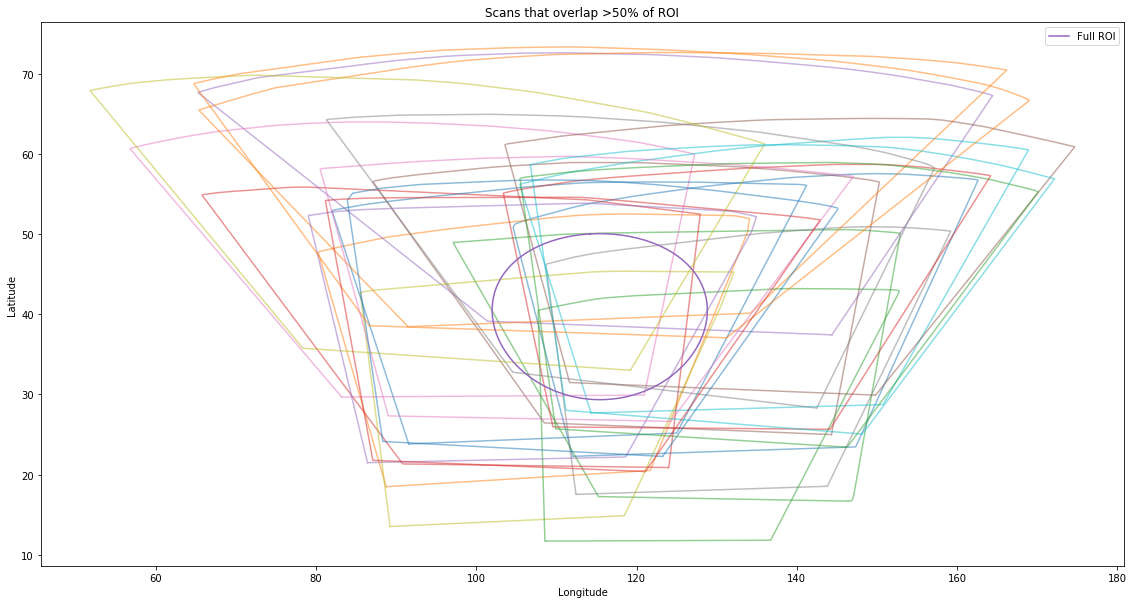

In [27]:
# Turn the ROI points into a shapely Polygon object:
lonROI, latROI, rROI = cart2sph(circleROI)
theROI = Polygon(np.array([lonROI, latROI]).transpose())

# Load boundaries.mat 
matFilename = "/Users/francis/Nextcloud/dropbox_dump/Dropbox/MATLAB/OREx/boundaries.mat"
mat_contents = sio.loadmat(matFilename)
edgesL2 = mat_contents["scanBdry"]

# Loop through boundaries and find scans that intersect >50% of the ROI:
scanIDs = []
plt.figure(figsize=(20,10))
for ii in range(edgesL2.shape[1]):
    name = edgesL2[0]["name"][ii]
    scanBoundary = Polygon(
        np.array(
            [edgesL2[0]["bdry"][ii][:, 0], edgesL2[0]["bdry"][ii][:, 1]]
        ).transpose()
    )

    SB2 = scanBoundary.convex_hull
    if SB2.area > 5000:
        continue
    intersection = theROI.intersection(SB2)
    if intersection.area / theROI.area > 0.5:
        scanIDs.append(name.tolist())
        plt.plot(*SB2.exterior.xy,alpha=0.5)
plt.plot(*theROI.exterior.xy,label='Full ROI')
plt.gca().set_aspect("equal", adjustable="box")
plt.legend()
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Scans that overlap >50% of ROI');

print(f'Relevant scans are:\n {scanIDs}')